## SciPy's `solve_ivp` (For Comparison)
As of CyRK v0.13.0, on a mid-tier desktop the following timings were found:

- SciPy.solve_ivp :  9.61   ms
- CyRK.nbsolve_ivp:  0.157  ms
- CyRK.pysolve_ivp:  0.348  ms
- CyRK.cysolve_ivp:  0.042  ms

In [1]:
import CyRK
print("CyRK Version:", CyRK.__version__)

CyRK Version: 0.14.0


Was Integration was successful? True
The solver successfully reached the end of the integration interval.


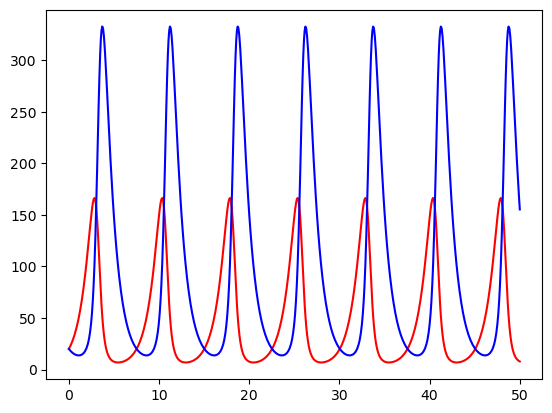

In [2]:
def diffeq(t, y):
    dy = np.empty_like(y)
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    return dy

import numpy as np
from scipy.integrate import solve_ivp

initial_conds = np.asarray((20., 20.), dtype=np.float64, order='C')
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

result = \
    solve_ivp(diffeq, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol)

print("Was Integration was successful?", result.success)
print(result.message)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result.t, result.y[0], c='r')
ax.plot(result.t, result.y[1], c='b')
plt.show()

In [3]:
%timeit solve_ivp(diffeq, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol)

9.61 ms ± 206 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## `nbsolve_ivp` Example

Was Integration was successful? True
Integration completed without issue.
Size of solution:  360


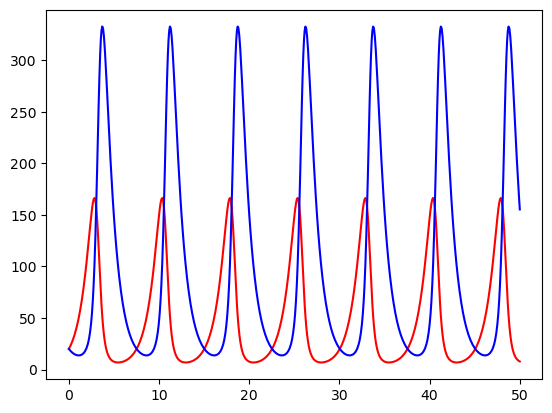

In [4]:
from numba import njit
@njit
def diffeq_nb(t, y):
    dy = np.empty_like(y)
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    return dy

import numpy as np
from CyRK import nbsolve_ivp

initial_conds = np.asarray((20., 20.), dtype=np.float64, order='C')
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

result = \
    nbsolve_ivp(diffeq_nb, time_span, initial_conds, rk_method=1, rtol=rtol, atol=atol)

print("Was Integration was successful?", result.success)
print(result.message)
print("Size of solution: ", result.size)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result.t, result.y[0], c='r')
ax.plot(result.t, result.y[1], c='b')
plt.show()

In [5]:
%timeit nbsolve_ivp(diffeq_nb, time_span, initial_conds, rk_method=1, rtol=rtol, atol=atol)

157 μs ± 975 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## `pysolve_ivp` Example

Was Integration was successful? True
Integration completed without issue.
Size of solution:  360


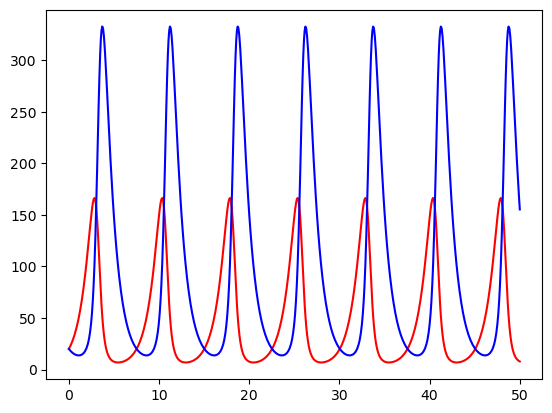

In [6]:
# Note if using this format, `dy` must be the first argument. Additionally, a special flag must be set to True when calling pysolve_ivp, see below.
def cy_diffeq(dy, t, y):
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]

# Since this is pure python we can njit it safely
from numba import njit
cy_diffeq = njit(cy_diffeq)
    
import numpy as np
from CyRK import pysolve_ivp

initial_conds = np.asarray((20., 20.), dtype=np.float64, order='C')
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

result = \
    pysolve_ivp(cy_diffeq, time_span, initial_conds, method="RK45", rtol=rtol, atol=atol,
                # Note if you did build a differential equation that has `dy` as the first argument then you must pass the following flag as `True`.
                # You could easily pass the `diffeq_nb` example which returns dy. You would just set this flag to False (and experience a hit to your performance).
                pass_dy_as_arg=True)

print("Was Integration was successful?", result.success)
print(result.message)
print("Size of solution: ", result.size)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result.t, result.y[0], c='r')
ax.plot(result.t, result.y[1], c='b')
plt.show()

In [7]:
%timeit pysolve_ivp(cy_diffeq, time_span, initial_conds, method="RK45", rtol=rtol, atol=atol, pass_dy_as_arg=True)

348 μs ± 12.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## `cysolve_ivp` Example

In [8]:
# Hack the cython magic so that it can set the correct C++ standard.
%load_ext Cython
import sys
from Cython.Build import IpythonMagic

orig_cython = IpythonMagic.CythonMagics.cython

def patched_cython(self, line, cell):
    # Add platform-correct C++ standard flag if not already present
    if "/std:c++" not in line and "-std=c++" not in line:
        if sys.platform.startswith("win"):
            line += " --cplus -c /std:c++20"
        else:
            line += " --cplus -c -std=c++20"
            
    return orig_cython(self, line, cell)

# Preserve the magic parser attribute so IPython still knows how to parse
patched_cython.parser = orig_cython.parser

# Patch it in
IpythonMagic.CythonMagics.cython = patched_cython

ip = get_ipython()
ip.register_magics(IpythonMagic.CythonMagics)

In [9]:
%%cython --force
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
from libcpp.utility cimport move
from libcpp.vector cimport vector

import numpy as np
cimport numpy as np
np.import_array()

# Note the "distutils" and "cython" headers above are functional. They tell cython how to compile the code. In this case we want to use C++ and to turn off several safety checks (which improve performance).

# The cython diffeq is much less flexible than the others described above. It must follow this format, including the type information. 
# Currently, CyRK only allows additional arguments to be passed in as a double array pointer (they all must be of type double). Mixed type args will be explored in the future if there is demand for it (make a GitHub issue if you'd like to see this feature!).
# The "noexcept nogil" tells cython that the Python Global Interpretor Lock is not required, and that no exceptions should be raised by the code within this function (both improve performance).
# If you do need the gil for your differential equation then you must use the `cysolve_ivp_gil` function instead of `cysolve_ivp`

# Import the required functions from CyRK
from CyRK cimport cysolve_ivp, DiffeqFuncType, WrapCySolverResult, CySolveOutput, PreEvalFunc

# Note that currently you must provide the "char* args, PreEvalFunc pre_eval_func" as inputs even if they are unused.
# See "Advanced CySolver.md" in the documentation for information about these parameters.
cdef void cython_diffeq(double* dy, double t, double* y, char* args, PreEvalFunc pre_eval_func) noexcept nogil:
    
    # Unpack args
    # CySolver assumes an arbitrary data type for additional arguments. So we must cast them to the array of 
    # doubles that we want to use for this equation
    cdef double* args_as_dbls = <double*>args
    cdef double a = args_as_dbls[0]
    cdef double b = args_as_dbls[1]
    
    # Build Coeffs
    cdef double coeff_1 = (1. - a * y[1])
    cdef double coeff_2 = (b * y[0] - 1.)
    
    # Store results
    dy[0] = coeff_1 * y[0]
    dy[1] = coeff_2 * y[1]
    # We can also capture additional output with cysolve_ivp.
    dy[2] = coeff_1
    dy[3] = coeff_2

# Import the required functions from CyRK
from CyRK cimport cysolve_ivp, DiffeqFuncType, WrapCySolverResult, CySolveOutput

# Let's get the integration number for the RK45 method
from CyRK cimport ODEMethod

# Now let's import cysolve_ivp and build a function that runs it. We will not make this function `cdef` like the diffeq was. That way we can run it from python (this is not a requirement. If you want you can do everything within Cython).
# Since this function is not `cdef` we can use Python types for its input. We just need to clean them up and convert them to pure C before we call cysolve_ivp.
def run_cysolver(tuple t_span, double[::1] y0):
    
    # Cast our diffeq to the accepted format
    cdef DiffeqFuncType diffeq = cython_diffeq
    
    # Convert the python user input to pure C types
    cdef size_t num_y          = len(y0)
    cdef double t_start        = t_span[0]
    cdef double t_end          = t_span[1]
    cdef vector[double] y0_vec = vector[double](num_y)
    cdef size_t yi
    for yi in range(num_y):
        y0_vec[yi] = y0[yi]

    # Assume constant additional arguments
    # These args are stored in a vector<char>
    cdef vector[char] args_vec = vector[char](2 * sizeof(double)) # Size of vector is size of arg datatype x number of args.

    # Convert to double pointer to more easily populate the vector.
    cdef double* args_as_dbl = <double*>args_vec.data()
    args_as_dbl[0] = 0.01
    args_as_dbl[1] = 0.02
    # Keep in mind these args could be any arbitrary C/C++ structure.

    # Run the integrator!
    cdef CySolveOutput result = cysolve_ivp(
        diffeq,
        t_start,
        t_end,
        y0_vec,
        method = ODEMethod.RK45, # Integration method
        rtol = 1.0e-7,
        atol = 1.0e-8,
        args_vec = args_vec,
        num_extra = 2
    )

    # The CySolveOutput is not accesible via Python. We need to wrap it first
    cdef WrapCySolverResult pysafe_result = WrapCySolverResult()
    pysafe_result.set_cyresult_pointer(move(result))

    return pysafe_result


Content of stdout:
_cython_magic_25f9a7c5fa494c2810671dff3dec8fd09a67cfece4528daf7441ae18c48dd9d4.cpp
C:\Users\joepr\miniforge3\envs\cyrk313\Lib\site-packages\numpy\_core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_25f9a7c5fa494c2810671dff3dec8fd09a67cfece4528daf7441ae18c48dd9d4.cpp(25280): warning C4551: function call missing argument list
C:\Users\joepr\.ipython\cython\_cython_magic_25f9a7c5fa494c2810671dff3dec8fd09a67cfece4528daf7441ae18c48dd9d4.cpp(25281): warning C4551: function call missing argument list
C:\Users\joepr\.ipython\cython\_cython_magic_25f9a7c5fa494c2810671dff3dec8fd09a67cfece4528daf7441ae18c48dd9d4.cpp(25282): warning C4551: function call missing argument list
C:\Users\joepr\.ipython\cython\_cython_magic_25f9a7c5fa494c2810671dff3dec8fd09a67cfece4528daf7441ae18c48dd9d4.cpp(25405): warning C4551: function call missing

Was Integration was successful? True
Integration completed without issue.
Size of solution:  360


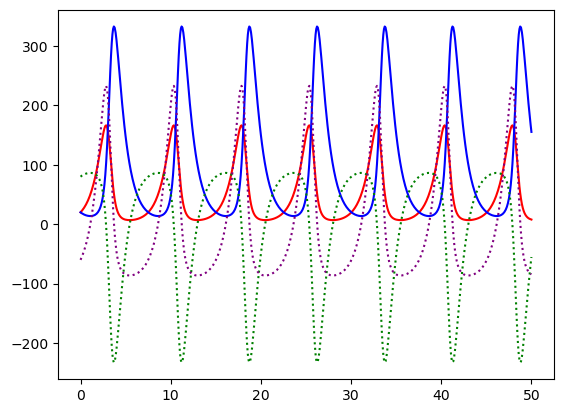

In [10]:
# Assume we are working in a Jupyter notebook so we don't need to import `run_cysolver` if it was defined in an earlier cell.
# from my_cython_code import run_cysolver

import numpy as np
initial_conds = np.asarray((20., 20.), dtype=np.float64, order='C')
time_span = (0., 50.)

result = run_cysolver(time_span, initial_conds)

print("Was Integration was successful?", result.success)
print(result.message)
print("Size of solution: ", result.size)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result.t, result.y[0], c='r')
ax.plot(result.t, result.y[1], c='b')

# Can also plot the extra output. They are small for this example so scaling them up by 100
ax.plot(result.t, 100*result.y[2], c='green', ls=':')
ax.plot(result.t, 100*result.y[3], c='purple', ls=':')
plt.show()

In [11]:
%timeit run_cysolver(time_span, initial_conds)

43.4 μs ± 215 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Result Structure
Below are the details of the Python-accesible CySolverResult object (called `WrapCySolverResult` defined in "cysolver_api.pyx").

In [12]:
# First run pysolver to get a result
from numba import njit
import numpy as np
from CyRK import pysolve_ivp

@njit
def cy_diffeq(dy, t, y):
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
initial_conds = np.asarray((20., 20.), dtype=np.float64, order='C')
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8
result = pysolve_ivp(cy_diffeq, time_span, initial_conds, method="RK45", rtol=rtol, atol=atol, pass_dy_as_arg=True, dense_output=True)

# Basic information
print("result.success =           ", result.success)
print("result.message =           ", result.message)
print("result.integration_method =", result.integration_method)
print("result.steps_taken =       ", result.steps_taken)
print("result.num_y =             ", result.num_y)
print("result.status =            ", result.status)
print("result.status_message =    ", result.status_message)
print()

# More detailed information (helpful for debugging)
result.print_diagnostics()
print()

# Data arrays (just printing the first few)
print("result.t[:5]    =", result.t[:5])
print("result.y[0, :5] =", result.y[0, :5])
print("result.y[1, :5] =", result.y[1, :5])
print()

# Since we captured dense outputs, we can make calls to the diffeq solution
new_t = 25.5
print("Solution at new_t:", result.call(new_t))
new_t_arr = np.linspace(20.0, 22.0, 5)
y_at_t_arr = result.call_vectorize(new_t_arr)
print("Solution at new_t_arr:\n\ty0=", y_at_t_arr[0,:], "\n\ty1=", y_at_t_arr[1,:])
# Can also directly call the result with either a float or an array
print("Direct call new_t:", result(new_t))

result.success =            True
result.message =            Integration completed without issue.
result.integration_method = Explicit Runge-Kutta method of order 5(4)
result.steps_taken =        359
result.num_y =              2
result.status =             1
result.status_message =     Integration completed without issue.

----------------------------------------------------
CyRK v0.14.0 - WrapCySolverResult Diagnostic.
----------------------------------------------------
# of y:       2.
# of dy:      2.
# of events:  0.
Success:      True.
Error Code:   1.
Size:         360.
Steps Taken:  359.
Event Termination:  False.
Integrator Message:
	Integration completed without issue.

----------------- CySolverResult -------------------
Capture Extra:          False.
Capture Dense Output:   True.
Integration Direction:  Forward.
Integration Method:     Explicit Runge-Kutta method of order 5(4).
# of Interpolates:      360.

------------------ CySolverBase --------------------
Status #:   1

## `t_eval` and dense output example
Read more about `t_eval` and dense output in "Documentation/Dense Output and t_eval.md"

Regular Shape:  (2, 60)
t_eval Shape:  (2, 500)
Dense Shape:  (2, 250)


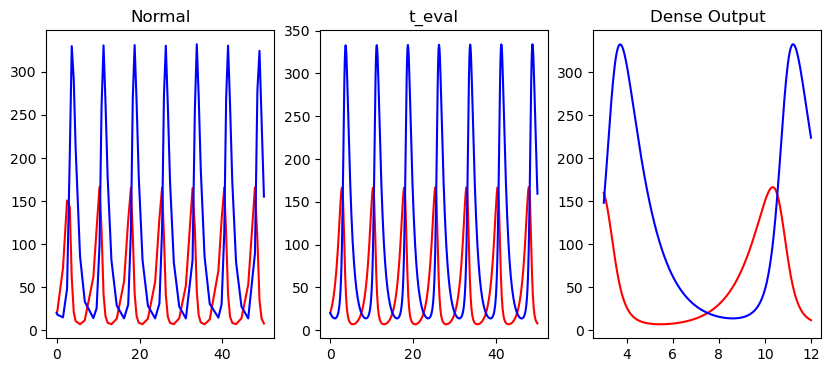

In [13]:
def cy_diffeq(dy, t, y):
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]

from numba import njit
cy_diffeq = njit(cy_diffeq)
    
import numpy as np
from CyRK import pysolve_ivp

initial_conds = np.asarray((20., 20.), dtype=np.float64, order='C')
time_span = (0., 50.)
rtol = 1.0e-4
atol = 1.0e-5

result_normal = \
    pysolve_ivp(cy_diffeq, time_span, initial_conds, method="DOP853", rtol=rtol, atol=atol,
                pass_dy_as_arg=True)

print('Regular Shape: ', result_normal.y.shape)

# Use t_eval to provide more data points than the integrator used
t_eval = np.linspace(0., 50.0, 500)
result_t_eval = \
    pysolve_ivp(cy_diffeq, time_span, initial_conds, method="RK45", rtol=rtol, atol=atol,
                t_eval=t_eval,
                pass_dy_as_arg=True)

print('t_eval Shape: ', result_t_eval.y.shape)

# Or we could get the dense output and treat the result as a function
result_dense = \
    pysolve_ivp(cy_diffeq, time_span, initial_conds, method="RK45", rtol=rtol, atol=atol,
                dense_output=True,
                pass_dy_as_arg=True)

t_dense = np.linspace(3.0, 12.0, 250)
y_dense = result_dense(t_dense)
print('Dense Shape: ', y_dense.shape)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, figsize=(10., 4.0))
axes[0].plot(result_normal.t, result_normal.y[0], c='r')
axes[0].plot(result_normal.t, result_normal.y[1], c='b')
axes[0].set(title='Normal')

axes[1].plot(result_t_eval.t, result_t_eval.y[0], c='r')
axes[1].plot(result_t_eval.t, result_t_eval.y[1], c='b')
axes[1].set(title='t_eval')

axes[2].plot(t_dense, y_dense[0], c='r')
axes[2].plot(t_dense, y_dense[1], c='b')
axes[2].set(title='Dense Output')

plt.show()

## Backward Integration

Was Integration was successful? True
The solver successfully reached the end of the integration interval.
solve_ivp shape: (2, 173)


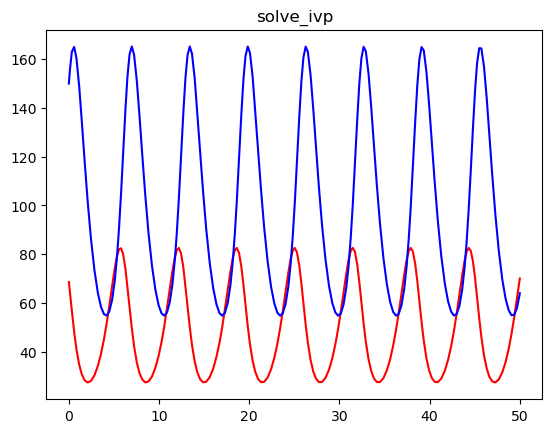

Was Integration was successful? True
The solver successfully reached the end of the integration interval.
pysolve_ivp shape: (2, 173)


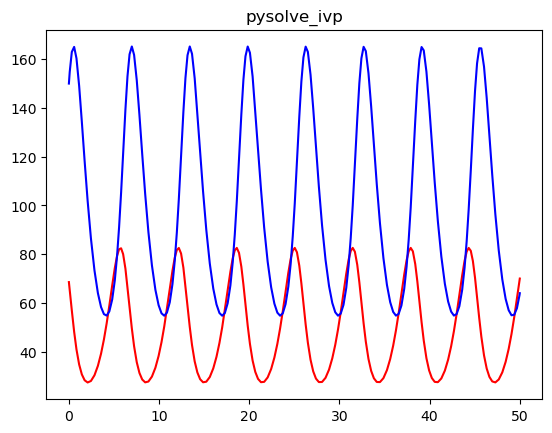

In [14]:
def diffeq(t, y):
    dy = np.empty_like(y)
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    return dy

import numpy as np
from scipy.integrate import solve_ivp

initial_conds = np.asarray((70, 64.), dtype=np.float64, order='C')
# time_span = (0., 50.)
time_span = (50., 0.)
rtol = 1.0e-6
atol = 1.0e-8

t_eval = None
# t_eval = np.linspace(0.0, 50.0, 30)
# t_eval = np.linspace(50.0, 0.0, 30)


result = \
    solve_ivp(diffeq, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol, t_eval=t_eval)

print("Was Integration was successful?", result.success)
print(result.message)
print("solve_ivp shape:", result.y.shape)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result.t, result.y[0], c='r')
ax.plot(result.t, result.y[1], c='b')
ax.set(title='solve_ivp')
plt.show()


from CyRK import pysolve_ivp
result_cy = \
    pysolve_ivp(diffeq, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol, t_eval=t_eval)

print("Was Integration was successful?", result.success)
print(result.message)
print("pysolve_ivp shape:", result_cy.y.shape)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(result_cy.t, result_cy.y[0], c='r')
ax.plot(result_cy.t, result_cy.y[1], c='b')
ax.set(title='pysolve_ivp')
plt.show()


## Backward Integration (with Dense)

Was Integration was successful? True
The solver successfully reached the end of the integration interval.
solve_ivp shape: (2, 175)


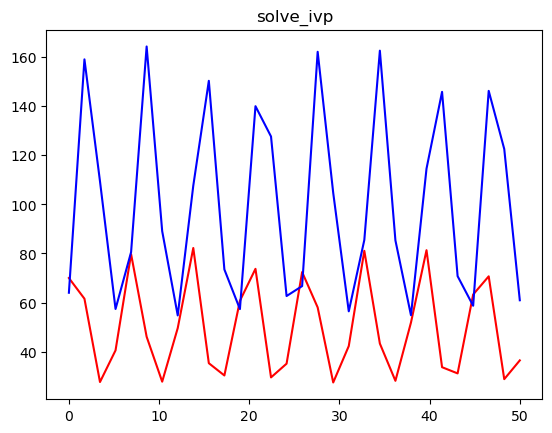

Was Integration was successful? True
The solver successfully reached the end of the integration interval.
pysolve_ivp shape: (2, 175)


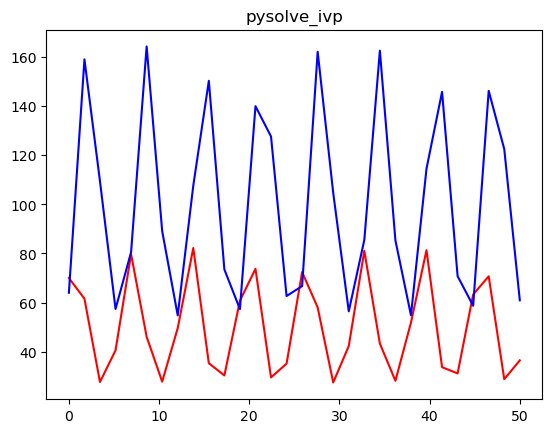

True


In [15]:
def diffeq(t, y):
    dy = np.empty_like(y)
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    return dy

import numpy as np
from scipy.integrate import solve_ivp

initial_conds = np.asarray((70, 64.), dtype=np.float64, order='C')
time_span = (0., 50.)
# time_span = (50., 0.)
rtol = 1.0e-6
atol = 1.0e-8


t_eval = np.linspace(0.0, 50.0, 30)
# t_eval = np.linspace(50.0, 0.0, 30)

result = \
    solve_ivp(diffeq, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol, dense_output=True)

print("Was Integration was successful?", result.success)
print(result.message)
print("solve_ivp shape:", result.y.shape)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sci_dense = result.sol(t_eval)
ax.plot(t_eval, sci_dense[0], c='r')
ax.plot(t_eval, sci_dense[1], c='b')
ax.set(title='solve_ivp')
plt.show()


from CyRK import pysolve_ivp
result_cy = \
    pysolve_ivp(diffeq, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol, dense_output=True)

print("Was Integration was successful?", result.success)
print(result.message)
print("pysolve_ivp shape:", result_cy.y.shape)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
pysolve_dense = result_cy(t_eval)
ax.plot(t_eval, pysolve_dense[0], c='r')
ax.plot(t_eval, pysolve_dense[1], c='b')
ax.set(title='pysolve_ivp')
plt.show()

print(np.allclose(pysolve_dense, sci_dense))


## Events

### Events with SciPy

In [16]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Example with SciPy
def event_func_1(t, y, a, b, c):

    # Check if t greater than or equal to 5.0
    if t >= 5.0:
        return 0.0
    else:
        return 1.0

def event_func_2(t, y, a, b, c):

    # Check y values.
    # In the time span [0,10]: 
    #    y_0  starts at 1, spikes then goes below zero and oscillates with a min below -10. Have this return if y_0 < -10
    if y[0] < -10.0:
        return 0.0
    elif y[2] > 30.0:
        return 0.0
    else:
        return 1.0


def event_func_3(t, y, a, b, c):

    # We won't actually use the args but lets just check they are correct.
    args_correct = False
    if a == 10.0 and b == 28.0 and c == 8.0 / 3.0:
        args_correct = True

    # Then return events if args are correct and t greater than 8
    if args_correct:
        return 0.0
    else:
        return 1.0

def lorenz_diffeq(t, y, a, b, c):
    # Unpack y
    y0 = y[0]
    y1 = y[1]
    y2 = y[2]

    dy = np.empty(3, dtype=np.float64)
    
    dy[0] = a * (y1 - y0)
    dy[1] = y0 * (b - y2) - y1
    dy[2] = y0 * y1 - c * y2
    return dy

def run_scipy_with_events(terminate = False):

    event_func_1.direction = 0
    event_func_1.terminal = 10000
    if terminate:
        event_func_1.terminal = 1
    event_func_2.direction = 0
    event_func_2.terminal = 10000
    event_func_3.direction = 0
    event_func_3.terminal = 10000


    time_span = (0.0, 10.0)
    y0 = np.asarray([1.0, 0.0, 0.0])
    args = (10.0, 28.0, 8.0/3.0)
    solution = solve_ivp(lorenz_diffeq, time_span, y0, method="RK45",
                         args=args, rtol=1.0e-6, atol=1.0e-6, t_eval=None, dense_output=False,
                         events=(event_func_1, event_func_2, event_func_3))

    return solution

10.8 ms ± 294 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


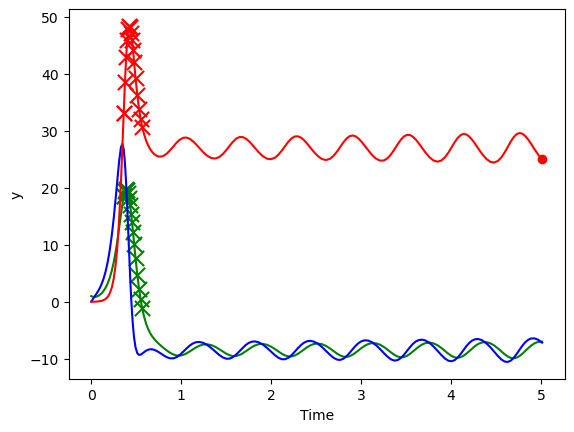

In [17]:
# SciPy Times
#  terminate off: 23.6ms; 23.7ms; 23.8ms
#  terminate on:  10.5ms; 10.3ms; 10.4ms

terminate = True
solution = run_scipy_with_events(terminate)

%timeit run_scipy_with_events(terminate)

fig, ax = plt.subplots()
ax.plot(solution.t, solution.y[0], label='y0', c='g')
ax.plot(solution.t, solution.y[1], label='y1', c='b')
ax.plot(solution.t, solution.y[2], label='y2', c='r')
# Event 1 will be dots.
ax.scatter(solution.t_events[0], solution.y_events[0][:, 2], c='r', marker='o')
# Event 2 will be X's
ax.scatter(solution.t_events[1], solution.y_events[1][:, 0], c='g', marker='x', s=120)
ax.scatter(solution.t_events[1], solution.y_events[1][:, 2], c='r', marker='x', s=120)
# Event 3 we won't plot because it should be every point.
ax.set(xlabel='Time', ylabel='y')
plt.show()

### Events with pysolve_ivp

In [18]:
import numpy as np
from CyRK import pysolve_ivp
import matplotlib.pyplot as plt
from numba import njit

# Example with SciPy
@njit
def event_func_1(t, y, a, b, c):

    # Check if t greater than or equal to 5.0
    if t >= 5.0:
        return 0.0
    else:
        return 1.0

@njit
def event_func_2(t, y, a, b, c):

    # Check y values.
    # In the time span [0,10]: 
    #    y_0  starts at 1, spikes then goes below zero and oscillates with a min below -10. Have this return if y_0 < -10
    if y[0] < -10.0:
        return 0.0
    elif y[2] > 30.0:
        return 0.0
    else:
        return 1.0

@njit
def event_func_3(t, y, a, b, c):

    # We won't actually use the args but lets just check they are correct.
    args_correct = False
    if a == 10.0 and b == 28.0 and c == 8.0 / 3.0:
        args_correct = True

    # Then return events if args are correct and t greater than 8
    if args_correct:
        return 0.0
    else:
        return 1.0

@njit
def lorenz_diffeq(dy, t, y, a, b, c):
    # Unpack y
    y0 = y[0]
    y1 = y[1]
    y2 = y[2]
    
    dy[0] = a * (y1 - y0)
    dy[1] = y0 * (b - y2) - y1
    dy[2] = y0 * y1 - c * y2

def run_pysove_with_events(terminate = False):

    event_func_1.direction = 0
    event_func_1.terminal = 10000
    if terminate:
        event_func_1.terminal = 1
    event_func_2.direction = 0
    event_func_2.terminal = 10000
    event_func_3.direction = 0
    event_func_3.terminal = 10000


    time_span = (0.0, 10.0)
    y0 = np.asarray([1.0, 0.0, 0.0])
    args = (10.0, 28.0, 8.0/3.0)
    solution = pysolve_ivp(lorenz_diffeq, time_span, y0, method="RK45",
                           args=args, rtol=1.0e-6, atol=1.0e-6, t_eval=None, dense_output=False, pass_dy_as_arg=True,
                           events=(event_func_1, event_func_2, event_func_3))

    return solution

314 μs ± 7.28 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


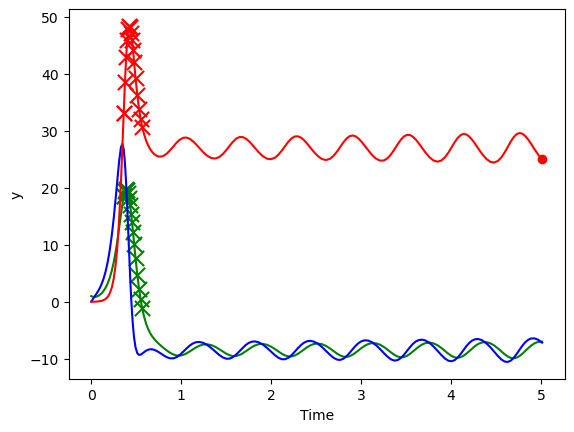

In [19]:
# PySolver Times
#   CyRK v0.16.0 (njit-off)
#     terminate off: 1.20ms; 1.22ms; 1.73ms
#     terminate on:  612us; 631us; 620us
#   CyRK v0.16.0 (njit-on)
#     terminate off: 642us; 634us; 648us
#     terminate on:  314us; 310us; 314us


terminate = True
solution = run_pysove_with_events(terminate)

%timeit run_pysove_with_events(terminate)

fig, ax = plt.subplots()
ax.plot(solution.t, solution.y[0], label='y0', c='g')
ax.plot(solution.t, solution.y[1], label='y1', c='b')
ax.plot(solution.t, solution.y[2], label='y2', c='r')
# Event 1 will be dots.
ax.scatter(solution.t_events[0], solution.y_events[0][2, :], c='r', marker='o')
# Event 2 will be X's
ax.scatter(solution.t_events[1], solution.y_events[1][0, :], c='g', marker='x', s=120)
ax.scatter(solution.t_events[1], solution.y_events[1][2, :], c='r', marker='x', s=120)
# Event 3 we won't plot because it should be every point.
ax.set(xlabel='Time', ylabel='y')
plt.show()